## Kaggle - Red Wine Quality Regression

This notebook contains the regression pipeline for the Red Wine Quality Kaggle dataset. This file is a python module that can be opened as a notebook using jupytext.

1. [Business/Data Understanding](#1.-Business/Data-Understanding)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Data Preparation](#3.-Data-Preparation)
4. [Modeling](#4.-Modeling)
5. [Evaluation](#5.-Evaluation)

[References](#References)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#from google.colab import files

### 1. Business/Data Understanding

Wine quality refers to the factors that go into producing a wine, as well as the indicators or characteristics that tell you if the wine is of high quality.

When you know what influences and signifies wine quality, you’ll be in a better position to make good purchases. You’ll also begin to recognize your preferences and how your favorite wines can change with each harvest. Your appreciation for wines will deepen once you’re familiar with wine quality levels and how wines vary in taste from region to region.

Some wines are higher-quality than others due to the factors described below. From climate to viticulture to winemaking, a myriad of factors make some wines exceptional and others run-of-the-mill.

### 2. Exploratory Data Analysis

The original dataset is divided into train and validation datasets. 

The exploration is applied to the train dataset, since the validation dataset is supposed to be unseen data. The basic aspects of the train data are shown bellow.

In [2]:
# raw_df = pd.read_csv('data/winequality-red.csv', header=0)
# train_df, validation_df = train_test_split(
#   raw_df,
#   test_size=0.2,
#   random_state=3
# )

# train_df.to_csv('data/train.csv', header=True, index=True)
# validation_df.to_csv('data/validation.csv', header=True, index=True)

From the dataset info we can see that the data is really clean, there are no null values. The target variable, quality, is composed by integers, while the features are floats.

In [3]:
train = pd.read_csv('data/train.csv', header=0, index_col=0)
print(f'Dataset shape: {train.shape} \n')
print(train.info())

Dataset shape: (1279, 12) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 606 to 1273
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 129.9 KB
None


Using the `describe()` method we can see the mean, standard deviation and the quartiles.

It is also worth noting that the quality only has 6 different values.

In [4]:
print(train['quality'].unique())
train.describe()

[7 5 6 3 8 4]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.357154,0.526771,0.272416,2.521384,0.086697,15.722439,46.295543,0.996766,3.310367,0.657834,10.429815,5.646599
std,1.752126,0.180265,0.195608,1.353377,0.044871,10.382304,33.401788,0.001864,0.156628,0.171037,1.061888,0.815664
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000,3.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,21.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,8.000000,0.520000,0.260000,2.200000,0.079000,13.000000,38.000000,0.996800,3.310000,0.620000,10.200000,6.000000
75%,9.300000,0.635000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997850,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


From the correlation plot, on the last row we can see that some features such as **sulphates** and **alcohol** are positive correlated to quality, while others like **volatile acidity** are negative correlated.

<AxesSubplot:>

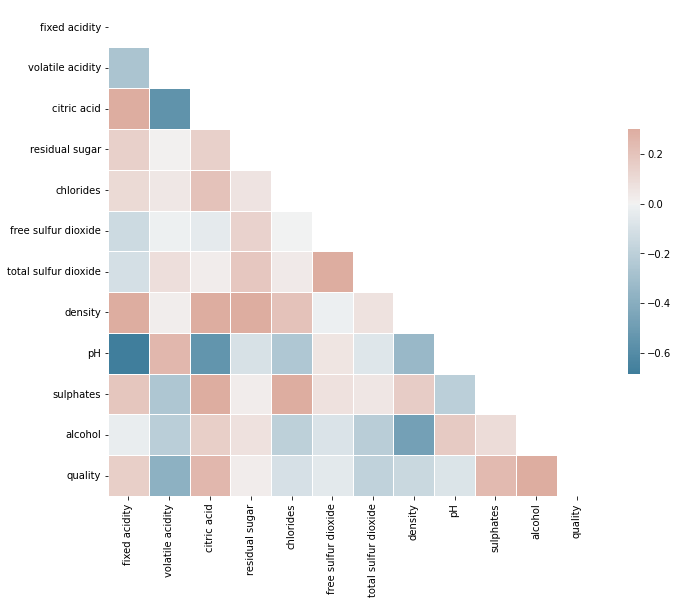

In [5]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the violin plots we can see which features contain outliers and how is the distribution of each feature

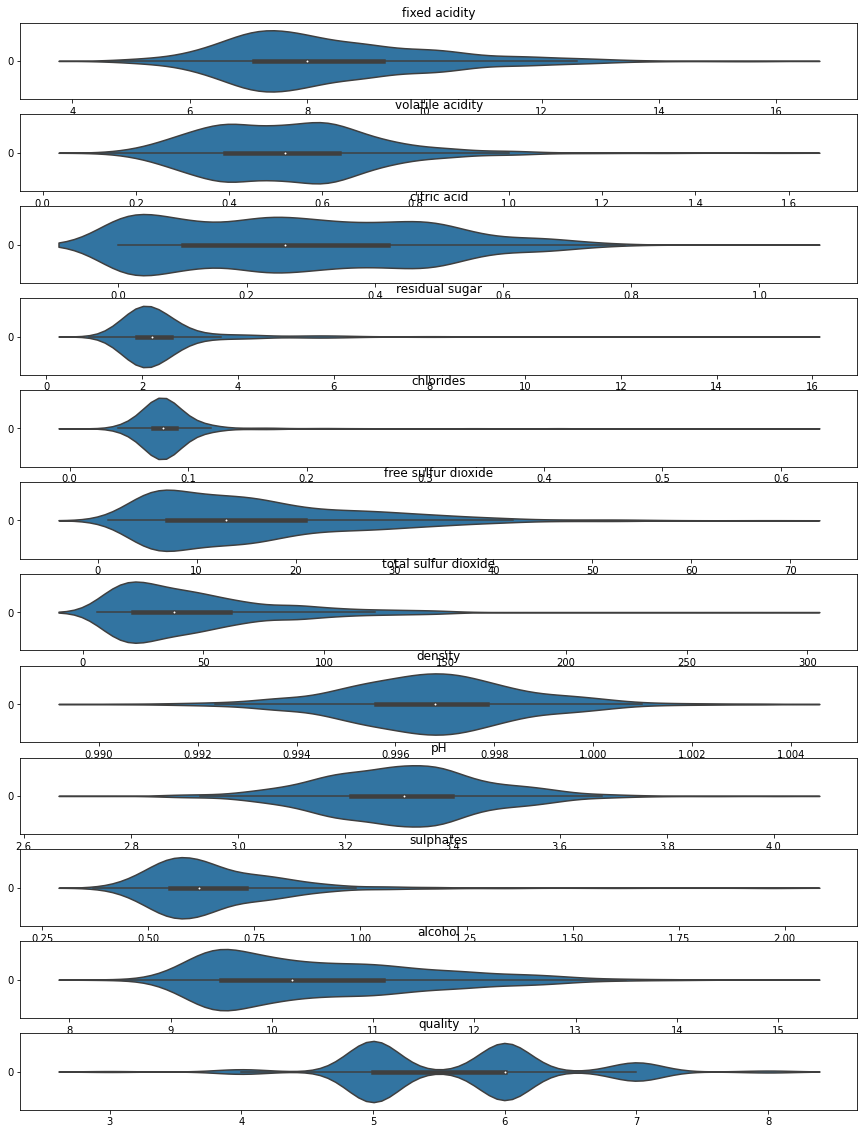

In [6]:
fig, axes = plt.subplots(12, 1, figsize=(15, 20))
for count, col in enumerate(train.columns):
  sns.violinplot(ax=axes[count], data=train[col], orient="h")
  axes[count].set_title(col)

### 3. Data Preparation

Since the data is already very clean, it is only necessary to scale the features. We are going to use 2 different scalers and compare the results obtained.

In [7]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1:]

standard_scaler_x = StandardScaler().fit(train_x)
standard_train_x = standard_scaler_x.transform(train_x)
standard_scaler_y = StandardScaler().fit(train_y)
standard_train_y = standard_scaler_y.transform(train_y)

minmax_scaler_x = MinMaxScaler().fit(train_x)
minmax_train_x = minmax_scaler_x.transform(train_x)
minmax_scaler_y = MinMaxScaler().fit(train_y)
minmax_train_y = minmax_scaler_y.transform(train_y)

### 4. Modeling

Train the performance from neural networks using 2 preprocessing scalers.

In [8]:
params = {
    'hidden_layer_sizes': [(i, ) for i in range(1, 22, 2)],
    'activation': ('identity', 'logistic', 'tanh', 'relu'),
    'batch_size': [50, 100, 200],
    'max_iter': [200, 400, 800],
}

base_mlp = MLPRegressor(random_state=3)
mlp = GridSearchCV(
    base_mlp,
    params,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5,
    return_train_score=True,
)
# mlp.fit(standard_train_x, standard_train_y)

# results = pd.DataFrame(mlp.cv_results_)
# results = results[['param_hidden_layer_sizes', 'param_activation',
#   'param_batch_size', 'param_max_iter','mean_test_score', 'rank_test_score',
#   'mean_train_score']]
# results.to_csv('mlp_standard_results.csv', index=False)
# files.download('mlp_standard_results.csv')

In [9]:
# mlp.fit(minmax_train_x, minmax_train_y)

# results = pd.DataFrame(mlp.cv_results_)
# results = results[['param_hidden_layer_sizes', 'param_activation',
#   'param_batch_size', 'param_max_iter','mean_test_score', 'rank_test_score',
#   'mean_train_score']]
# results.to_csv('mlp_minmax_results.csv', index=False)
# files.download('mlp_minmax_results.csv')

Evaluate the results output files

The results from the standard scaled MLP show that the best activation function is the logistic. But the best results are clealy overfitted. To adjust this ranking, one column were added, which represents the distance between test and train errors. The rows which the gap was greater than 5% were dropped from the ranking. The best model then was selected, a 9 hidden neurons, logistic activation, batch size equal of 50 and max iters of 400.

The process was repeat to the MinMax scaled MLP, in which the overfit was not perceived. The final model has 11 hidden neurons, tanh activation, batch size of 50 and max iters of 800.

In [10]:
standard_results = pd.read_csv('outputs/mlp_standard_results.csv')
standard_results['test/train'] = standard_results['mean_test_score']/standard_results['mean_train_score']
standard_results[standard_results['test/train'] < 1.05].sort_values(['rank_test_score'])

,param_hidden_layer_sizes,param_activation,param_batch_size,param_max_iter,mean_test_score,rank_test_score,mean_train_score,test/train
112,"(9,)",logistic,50,400,-0.786116,10,-0.751520,1.046034
163,"(21,)",logistic,100,400,-0.787316,14,-0.749924,1.049861
107,"(5,)",logistic,50,800,-0.787445,15,-0.754989,1.042988
151,"(13,)",logistic,100,400,-0.787649,17,-0.760753,1.035354
106,"(5,)",logistic,50,400,-0.787658,18,-0.758647,1.038240
...,...,...,...,...,...,...,...,...
231,"(1,)",tanh,100,200,-0.838225,386,-0.819545,1.022793
372,"(7,)",relu,200,200,-0.838570,387,-0.800334,1.047774
165,"(1,)",logistic,200,200,-0.843682,389,-0.834568,1.010922
66,"(1,)",identity,200,200,-0.849029,391,-0.840323,1.010360


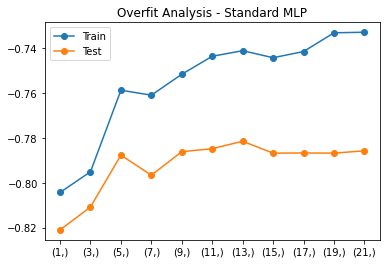

In [11]:
sample1 = standard_results.query("param_activation == 'logistic' & param_batch_size == 50 & param_max_iter == 400")
plt.plot(sample1['param_hidden_layer_sizes'], sample1['mean_train_score'], '-o', label='Train')
plt.plot(sample1['param_hidden_layer_sizes'], sample1['mean_test_score'], '-o', label='Test')
plt.legend()
plt.title('Overfit Analysis - Standard MLP')
plt.show()

In [12]:
minmax_results = pd.read_csv('outputs/mlp_minmax_results.csv')
minmax_results['test/train'] = minmax_results['mean_test_score']/minmax_results['mean_train_score']
minmax_results[minmax_results['test/train'] < 1.05].sort_values(['rank_test_score'])

,param_hidden_layer_sizes,param_activation,param_batch_size,param_max_iter,mean_test_score,rank_test_score,mean_train_score,test/train
215,"(11,)",tanh,50,800,-0.133154,1,-0.131527,1.012370
214,"(11,)",tanh,50,400,-0.133154,1,-0.131527,1.012370
213,"(11,)",tanh,50,200,-0.133154,1,-0.131527,1.012370
248,"(11,)",tanh,100,800,-0.133912,4,-0.132362,1.011717
247,"(11,)",tanh,100,400,-0.133912,4,-0.132362,1.011717
...,...,...,...,...,...,...,...,...
35,"(1,)",identity,100,800,-0.215795,390,-0.214900,1.004166
363,"(1,)",relu,200,200,-0.244325,393,-0.250713,0.974519
67,"(1,)",identity,200,400,-0.246537,394,-0.246297,1.000974
68,"(1,)",identity,200,800,-0.246537,394,-0.246297,1.000974


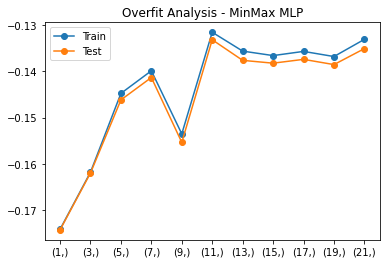

In [13]:
sample1 = minmax_results.query("param_activation == 'tanh' & param_batch_size == 50 & param_max_iter == 800")
plt.plot(sample1['param_hidden_layer_sizes'], sample1['mean_train_score'], '-o', label='Train')
plt.plot(sample1['param_hidden_layer_sizes'], sample1['mean_test_score'], '-o', label='Test')
plt.legend()
plt.title('Overfit Analysis - MinMax MLP')
plt.show()

### 5. Evaluation

Fitting the chosen models to the train dataset and predicting the quality of the wine on a never seen validation dataset shows that the results obtained from the standard scaled MLP have a better root mean squared error.

In [14]:
validation = pd.read_csv('data/validation.csv', header=0, index_col=0)

validation_x = validation.iloc[:,:-1]
validation_y = validation.iloc[:,-1:]
validation_y.reset_index(drop=True, inplace=True)

standard_validation_x = standard_scaler_x.transform(validation_x)
minmax_validation_x = minmax_scaler_x.transform(validation_x)

In [15]:
std_mlp = MLPRegressor(
    hidden_layer_sizes=(9,),
    activation='logistic',
    batch_size=50,
    max_iter=400,
    random_state=3
)

std_mlp.fit(standard_train_x, standard_train_y)
std_results = standard_scaler_y.inverse_transform(std_mlp.predict(standard_validation_x).reshape((320,1)))
std_y_pred = std_results.round()

/home/torn/repos/kaggle-redwine-regression/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/torn/repos/kaggle-redwine-regression/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
minmax_mlp = MLPRegressor(
    hidden_layer_sizes=(11,),
    activation='tanh',
    batch_size=50,
    max_iter=800,
    random_state=3
)

minmax_mlp.fit(minmax_train_x, minmax_train_y)
minmax_results = minmax_scaler_y.inverse_transform(minmax_mlp.predict(minmax_validation_x).reshape((320,1)))
minmax_y_pred = minmax_results.round()

/home/torn/repos/kaggle-redwine-regression/.venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
validation_y['std_pred'] = pd.Series(std_y_pred.reshape((320,)))
validation_y['minmax_pred'] = pd.Series(minmax_y_pred.reshape((320,)))
validation_y.head()
validation_y.to_csv('outputs/predictions.csv', index=False)

/tmp/ipykernel_10186/1482607587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_y['std_pred'] = pd.Series(std_y_pred.reshape((320,)))
/tmp/ipykernel_10186/1482607587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_y['minmax_pred'] = pd.Series(minmax_y_pred.reshape((320,)))


In [18]:
print(mean_squared_error(validation_y['quality'], validation_y['std_pred']))
print(mean_squared_error(validation_y['quality'], validation_y['minmax_pred']))

0.415625
0.44375


### References

[1] [Wine Quality Introduction](https://www.jjbuckley.com/wine-knowledge/blog/the-4-factors-and-4-indicators-of-wine-quality/1009) 